In [247]:
import numpy as np
import json
from collections import Counter
from matplotlib import pyplot as plt
import os
import pickle

In [248]:
def counter_to_array(counter, n_classes=10):
    array = np.zeros(n_classes, dtype=np.int64)
    for key, value in counter.items():
        array[key] += value
    return array

In [249]:
TASK = 'synthetic_classification_cnum3_dist10_skew0.5_seed0'

In [250]:
with open('/mnt/disk1/duongtn/ShapleyFL/fedtask/{}/data.json'.format(TASK), 'r') as f:
    data= json.load(f)

In [251]:
data.keys()

dict_keys(['store', 'client_names', 'dtest', 'Client0', 'Client1', 'Client2'])

In [252]:
print('test', len(data['dtest']['y']))
for client in data['client_names']:
    print(client, len(data[client]['dtrain']['y']), len(data[client]['dvalid']['y']))

test 173
Client0 402 81
Client1 495 99
Client2 395 79


In [253]:
counter = Counter(data['dtest']['y'])
print('test', counter_to_array(counter))
for client in data['client_names']:
    counter = Counter(data[client]['dtrain']['y'])
    print(client, counter_to_array(counter))

test [62  0  0  4 53  8  0  0  4 42]
Client0 [  0   0   0  60   0  66   0   0   0 276]
Client1 [479   0   0   0   0   0   0   0  16   0]
Client2 [  0   0   0   0 395   0   0   0   0   0]


In [254]:
train_len = np.array([len(data[client]['dtrain']['y']) for client in data['client_names']])
train_len_p = train_len / train_len.sum()
train_len_p

array([0.31114551, 0.38312693, 0.30572755])

In [255]:
train_len.sum()

1292

In [256]:
folder = 'fedtask/{}/record/'.format(TASK)
prefix = 'fedavg_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
DICT = dict()
files = os.listdir(folder)
files.sort(reverse=True)
for file in files:
    if file.startswith(prefix):
        with open(os.path.join(folder, file), 'r') as f:
            DICT[file.replace(prefix, '').replace('.json', '')] = np.array(json.load(f)['test_accuracy'])
DICT['0' * len(data['client_names'])] = np.zeros(101)

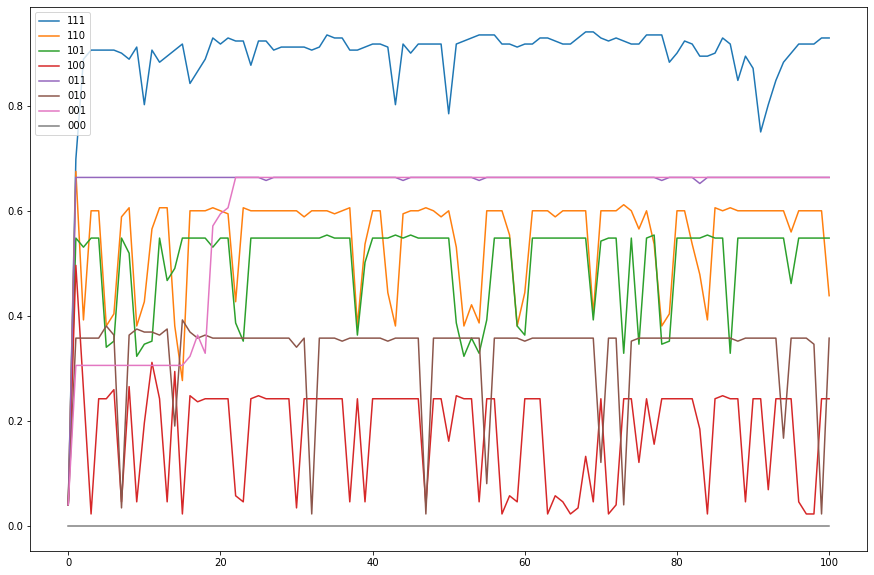

In [257]:
plt.figure(figsize=(15, 10))
for key, value in DICT.items():
    plt.plot(value[:], label=key)
plt.legend()
plt.show()

In [258]:
from bitsets import bitset
import itertools

In [259]:
CLIENTS_BITSET = bitset('clients_bitset', tuple(data['client_names']))

In [260]:
SV = dict()
for client in data['client_names']:
    result = 0.0
    rest_clients = [client_ for client_ in data['client_names'] if client_ != client]
    for i in range(0, len(rest_clients) + 1):
        a_i = 0.0
        count_i = 0
        for subset in itertools.combinations(rest_clients, i):
            # print(subset)
            a_i += DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                DICT[CLIENTS_BITSET(subset).bits()].max()
            if DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                DICT[CLIENTS_BITSET(subset).bits()].max() < 0:
                    print(client, subset)
            # print(DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][-1], DICT[CLIENTS_BITSET(subset).bits()][-1])
            count_i += 1
        # print(a_i, count_i)
        a_i = a_i / count_i
        result += a_i
    result = result / len(data['client_names'])
    SV[client] = result

Client0 ('Client2',)


In [261]:
sv = np.array(list(SV.values()))
sv = sv / sv.sum()
sv

array([0.30470348, 0.30777096, 0.38752556])

In [262]:
sum(SV.values())

0.9421965317919074

In [281]:
exact = list()
const_lambda = list()
optimal_lambda = dict()
for round_ in range(1, 101):
    # with open('SV_result/{}/min_max/minRound{}.npy'.format(TASK, round_), 'rb') as f:
    #     min_v = pickle.load(f)
    min_v = 0.0
    with open('SV_result/{}/min_max/maxRound{}.npy'.format(TASK, round_), 'rb') as f:
        max_v = pickle.load(f)
    with open('SV_result/{}/exact/Round{}.npy'.format(TASK, round_), 'rb') as f:
        exact.append((pickle.load(f) / (max_v - min_v)).tolist())
        # exact.append(pickle.load(f).tolist())
    with open('SV_result/{}/const_lambda/Round{}.npy'.format(TASK, round_), 'rb') as f:
        const_lambda.append(pickle.load(f).tolist())
    for ns in [7]:
        if ns not in optimal_lambda.keys():
            optimal_lambda[ns] = list()
        with open('SV_result/{}/optimal_lambda-{}/Round{}.npy'.format(TASK, ns, round_), 'rb') as f:
            # optimal_lambda[ns].append((pickle.load(f) / (max_v - min_v)).tolist())
            optimal_lambda[ns].append(pickle.load(f).tolist())
exact = np.array(exact)
const_lambda = np.array(const_lambda)
for key in optimal_lambda.keys():
    optimal_lambda[key] = np.array(optimal_lambda[key])
exact.shape, const_lambda.shape, *[opt.shape for opt in optimal_lambda.values()]

((100, 3), (100, 3), (100, 3))

No handles with labels found to put in legend.


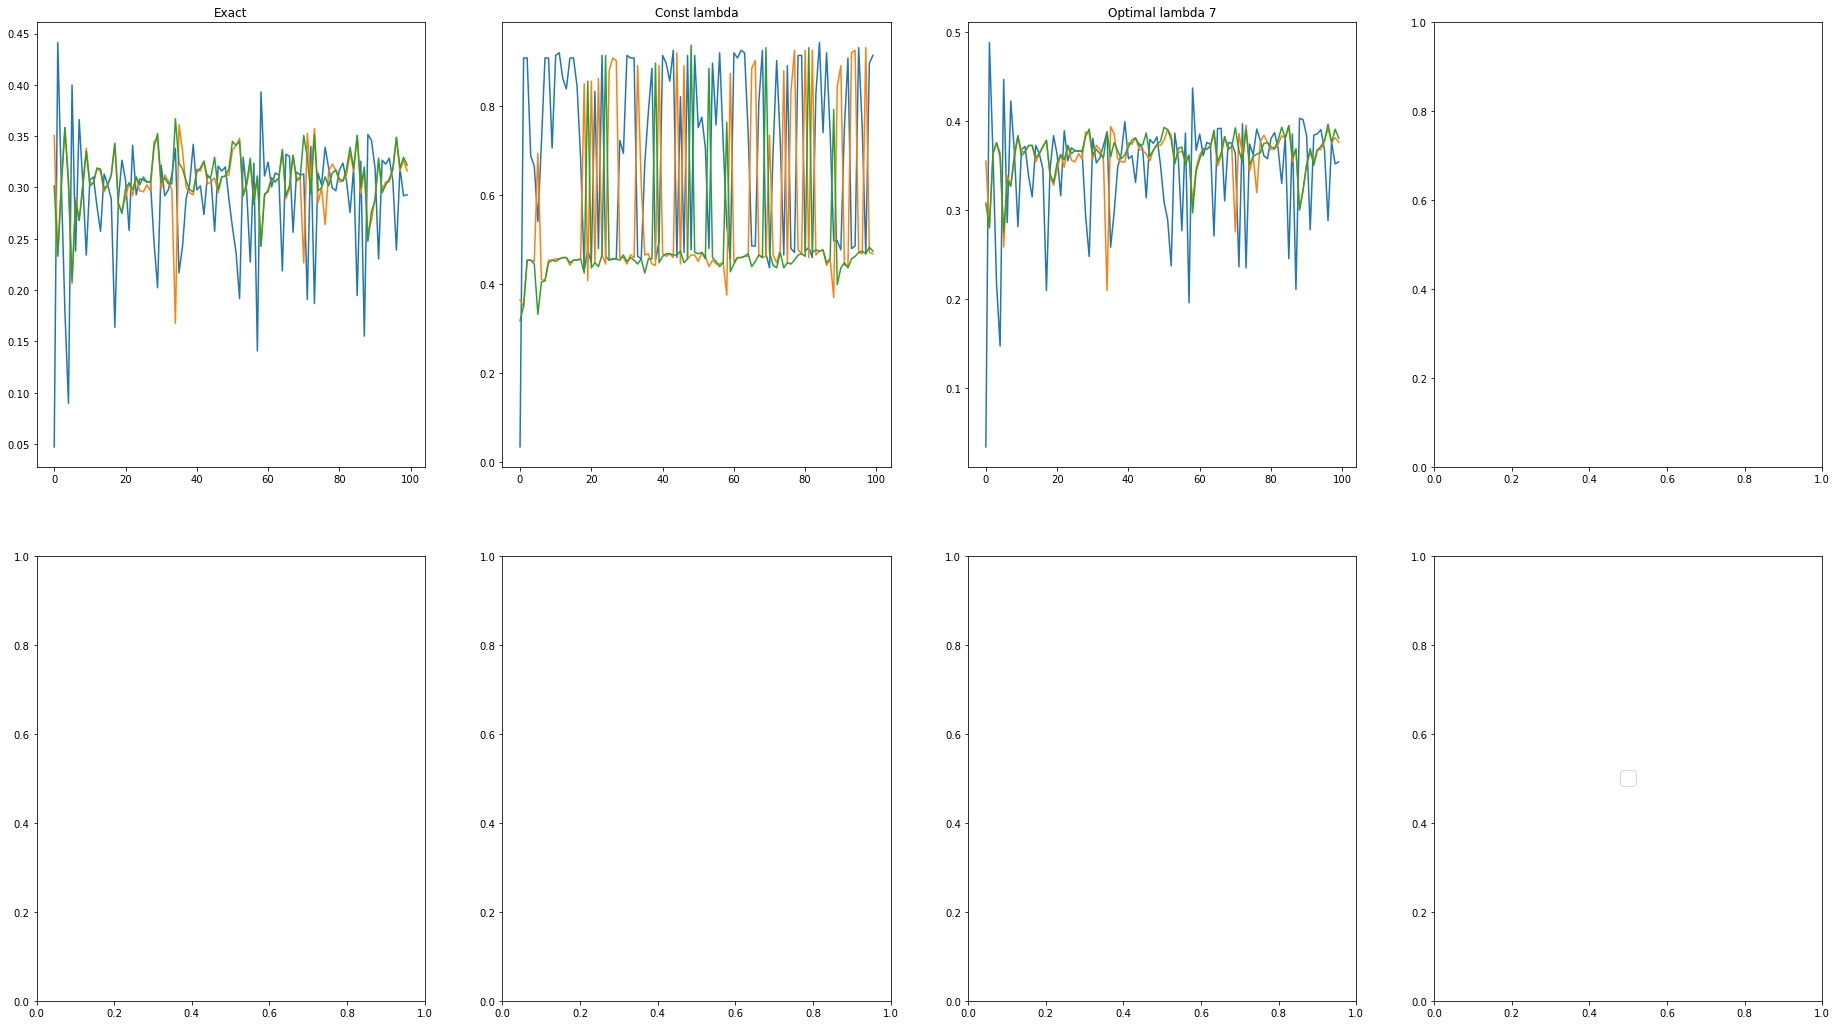

In [264]:
fig, ax = plt.subplots(nrows=2, ncols=4)
fig.set_figheight(18)
fig.set_figwidth(32)
ax[0, 0].set_title('Exact')
for client, clients_sv in zip(data['client_names'], exact.T):
    ax[0, 0].plot(clients_sv[:], label=client)
ax[0, 1].set_title('Const lambda')
for client, clients_sv in zip(data['client_names'], const_lambda.T):
    ax[0, 1].plot(clients_sv[:], label=client)
ax[0, 2].set_title('Optimal lambda 7')
for client, clients_sv in zip(data['client_names'], optimal_lambda[7].T):
    ax[0, 2].plot(clients_sv[:], label=client)
# ax[0, 3].set_title('Optimal lambda 40')
# for client, clients_sv in zip(data['client_names'], optimal_lambda[40].T):
#     ax[0, 3].plot(clients_sv[:], label=client)
# ax[1, 0].set_title('Optimal lambda 50')
# for client, clients_sv in zip(data['client_names'], optimal_lambda[50].T):
#     ax[1, 0].plot(clients_sv[:], label=client)
# ax[1, 1].set_title('Optimal lambda 60')
# for client, clients_sv in zip(data['client_names'], optimal_lambda[60].T):
#     ax[1, 1].plot(clients_sv[:], label=client)
# ax[1, 2].set_title('Optimal lambda 63')
# for client, clients_sv in zip(data['client_names'], optimal_lambda[63].T):
#     ax[1, 2].plot(clients_sv[:], label=client)
# for client, clients_sv in zip(data['client_names'], optimal_lambda[63].T):
#     ax[1, 3].plot(clients_sv[:0], label=client)
ax[1, 3].legend(loc='center', fontsize=20)
plt.show()

In [265]:
print("const lambda", np.abs(exact - const_lambda).sum())
for key, value in optimal_lambda.items():
    print("optimal lambda", key, np.abs(exact - value).sum())

const lambda 84.85741811175336
optimal lambda 7 16.456785115088483


In [276]:
def aggregate(values, exp=None, alpha=None):
    result = np.zeros(values.shape[1])
    if alpha is None:
        if exp is None:
            result = values.sum(axis=0)
        else:
            for i, value in enumerate(values):
                result += value / pow(i+1, 2)
    else:
        for i, value in enumerate(values):
            result += value * pow(alpha, i)
    # if result.min() < 0.0:
    #     result = result - result.min()
    result = result / result.sum()
    return result

In [267]:
corrs = list()
for alpha in np.arange(start=0.0, stop=1.0 + 1e-6, step=0.01):
    e = aggregate(exact, alpha=alpha)
    corrs.append(np.corrcoef(e, sv)[0, 1])
corrs = np.array(corrs)
np.arange(start=0.0, stop=1.0 + 1e-6, step=0.01)[corrs.argmax()]

1.0

In [268]:
corrs = list()
for exp in np.arange(start=0, stop=10 + 1e-6, step=0.1):
    e = aggregate(exact, exp=exp)
    corrs.append(np.corrcoef(e, sv)[0, 1])
corrs = np.array(corrs)
np.arange(start=0, stop=10 + 1e-6, step=0.1)[corrs.argmax()]

0.0

In [269]:
corrs = list()
for round_ in np.arange(start=1, stop=100 + 1e-6, step=1, dtype=int):
    e = aggregate(exact[:round_])
    corrs.append(np.corrcoef(e, sv)[0, 1])
corrs = np.array(corrs)
np.arange(start=1, stop=100 + 1e-6, step=1, dtype=int)[corrs.argmax()]

35

In [270]:
sv

array([0.30470348, 0.30777096, 0.38752556])

In [271]:
exact.sum(axis=0)

array([28.78805395, 30.59152216, 30.94990366])

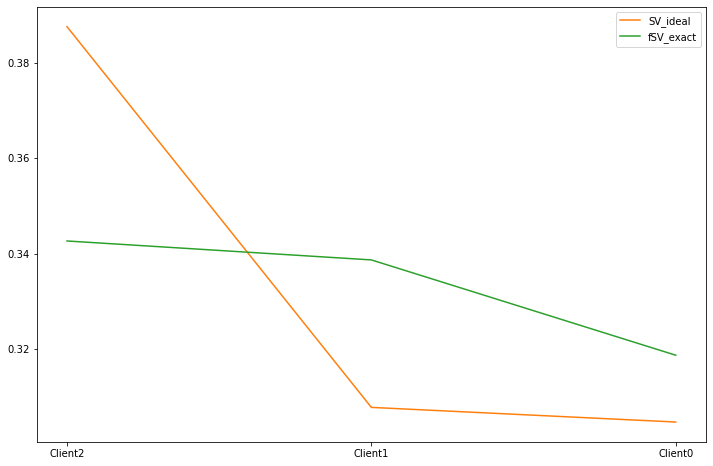

In [280]:
plt.figure(figsize=(12, 8))
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], train_len_p[np.argsort(sv)[::-1]], label='data', color='tab:blue')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], sv[np.argsort(sv)[::-1]], label='SV_ideal', color='tab:orange')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(exact)[np.argsort(sv)[::-1]], label='fSV_exact', color='tab:green')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(const_lambda)[np.argsort(sv)[::-1]], label='fSV_const_lambda', color='tab:red')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[7])[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_30', color='pink')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[40], exp=1.5)[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_40', color='plum')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[50], exp=1.5)[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_50', color='violet')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[7], exp=1.5)[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_7', color='mediumpurple')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[63], exp=1.5)[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_63', color='tab:purple')
plt.legend()
plt.show()

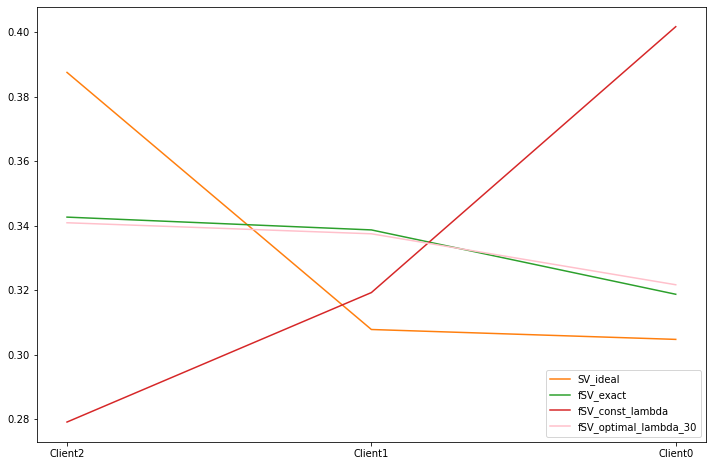

In [275]:
plt.figure(figsize=(12, 8))
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], train_len_p[np.argsort(sv)[::-1]], label='data', color='tab:blue')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], sv[np.argsort(sv)[::-1]], label='SV_ideal', color='tab:orange')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(exact[:])[np.argsort(sv)[::-1]], label='fSV_exact', color='tab:green')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(const_lambda[:])[np.argsort(sv)[::-1]], label='fSV_const_lambda', color='tab:red')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[7][:])[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_30', color='pink')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[40][:])[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_40', color='plum')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[50][:])[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_50', color='violet')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[60][:])[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_60', color='mediumpurple')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[63][:])[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_63', color='tab:purple')
plt.legend()
plt.show()

In [282]:
from sklearn.preprocessing import MinMaxScaler

In [297]:
X = np.array([1, 2, 3])
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_std
# X_scaled = X_std * (max - min) + min

array([0. , 0.5, 1. ])